### Download datasets

We can use the Hugging Face hub package to download data from the Global Streetscape repo. If the files are already present and up-to-date, they will not be downloaded again. Note that we are passing in the local data directory as specified in the environment/package config.

In [3]:
from streetscapes import conf
from huggingface_hub import hf_hub_download
import os
filename = hf_hub_download(repo_id="NUS-UAL/global-streetscapes", filename="data/contextual.csv", repo_type="dataset", local_dir=conf.DATA_DIR)
print(conf.DATA_DIR)
print(filename)

/home/peter/urban-m4/streetscapes/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/peter/urban-m4/streetscapes/local/streetscapes-data
/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/contextual.csv


There are quite a few files available. We found the following four files provide a good starting point.

In [2]:
for filename in [
    "contextual.csv",
    "metadata_common_attributes.csv",
    "segmentation.csv",
    "simplemaps.csv",
]:
    filename = hf_hub_download(
        repo_id="NUS-UAL/global-streetscapes", 
        filename=f"data/{filename}", 
        repo_type="dataset", 
        local_dir=conf.DATA_DIR
    )
    print(filename)

/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/contextual.csv
/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/metadata_common_attributes.csv
/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/segmentation.csv
/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/simplemaps.csv


### Exploring the data

One option to explore the data is using pandas. However, pandas might not be the most suitable in this case. It has trouble identifying data types and as a result, parses many columns into objects. It also has a tendency to load lots of data into memory. Notice the memory consumption below: the contextual dataset with (only) 10 columns already uses over 800MB. The other datasets are much bigger. 

In [8]:
import pandas as pd

df = pd.read_csv(conf.DATA_DIR / "data" / "contextual.csv")
print(df.info())

/tmp/ipykernel_3420239/1074163805.py:3: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(conf.DATA_DIR / "data" / "contextual.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10004551 entries, 0 to 10004550
Data columns (total 11 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   uuid                object
 1   source              object
 2   orig_id             int64 
 3   glare               object
 4   lighting_condition  object
 5   pano_status         object
 6   platform            object
 7   quality             object
 8   reflection          object
 9   view_direction      object
 10  weather             object
dtypes: int64(1), object(10)
memory usage: 839.6+ MB
None


DuckDB might be more suitable to explore this dataset. This package can query the data without loading it into memory. For example:

In [51]:
import duckdb

print(duckdb.sql(f"SELECT * FROM '{conf.DATA_DIR / 'data' / 'metadata_common_attributes.csv'}'"))

┌──────────────────────────────────────┬───────────┬──────────────────┬────────────────────┬────────────────────┬─────────────────────────┬───────┬───────┬───────┬───────┬────────┬────────┬────────────────────┬─────────────────┬────────────────────┬────────────────────┬────────────────┬────────────────────────┬────────────────────┐
│                 uuid                 │  source   │     orig_id      │        lat         │        lon         │     datetime_local      │ year  │ month │  day  │ hour  │ width  │ height │      heading       │ projection_type │        hFoV        │        vFoV        │ sequence_index │      sequence_id       │ sequence_img_count │
│               varchar                │  varchar  │      int64       │       double       │       double       │        timestamp        │ int64 │ int64 │ int64 │ int64 │ double │ double │       double       │     varchar     │       double       │       double       │     int64      │        varchar         │       int64        

DuckDB can also combine the dataframes very efficiently, so we can easily get a subset of the data using conditions on multiple CSVs:

In [54]:
duckdb.sql(f"""         
            SELECT *
            FROM read_csv('{conf.DATA_DIR}/data/contextual.csv') AS contextual
            JOIN read_csv('{conf.DATA_DIR}/data/simplemaps.csv') AS simplemaps
            USING (UUID, source, orig_id)
            WHERE simplemaps.city = 'Amsterdam' AND contextual.view_direction = 'side'
           """).df()

,uuid,source,orig_id,glare,lighting_condition,pano_status,platform,quality,reflection,view_direction,...,city_id,city_lat,city_lon,country,iso2,iso3,admin_name,capital,population,continent
0,b1d51d2e-e9ac-42a5-a61c-24b021cc023d,Mapillary,158020999514623,False,day,False,walking surface,good,False,side,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
1,ca99be07-83ad-4f7b-aab5-f3e7be852354,Mapillary,807338246832506,False,day,False,walking surface,good,True,side,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
2,1636e5eb-2c3f-46ee-b332-e80d9922f248,Mapillary,387774032286335,False,day,False,walking surface,good,False,side,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
3,356ced9c-7735-4ad8-b251-19950de24e99,Mapillary,180337743940218,False,day,False,walking surface,slightly poor,False,side,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
4,e1b3d462-c2f4-42a9-9f70-67a9a7f49203,Mapillary,518185585887113,False,day,False,walking surface,slightly poor,True,side,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4053,4bae19c3-3445-438c-96a4-d28f5f5b2bab,KartaView,1605309081,False,day,False,cycling surface,good,False,side,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
4054,8d162000-2094-4f2b-ac26-ac13b8c134e7,KartaView,1605303369,False,day,False,walking surface,good,False,side,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
4055,af6cec2a-d9ff-41ef-9d4c-3bb336af039c,KartaView,1605309145,False,day,False,cycling surface,good,False,side,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe
4056,31071801-28e5-4e77-80a9-c6b5b51b7eaa,KartaView,1605310313,False,day,False,walking surface,good,False,side,...,1528355309,52.3667,4.8833,Netherlands,NL,NLD,Noord-Holland,primary,862965.0,Europe


Now, we can add the third csv file to get the exact latitude and longitude of each image. Let's fetch the results into a pandas dataframe.

In [5]:
df = duckdb.sql(f"""         
            SELECT metadata.lat, metadata.lon, contextual.quality
            FROM read_csv('{conf.DATA_DIR}/data/contextual.csv') AS contextual
            JOIN read_csv('{conf.DATA_DIR}/data/simplemaps.csv') AS simplemaps
            USING (UUID, source, orig_id)
            JOIN read_csv('{conf.DATA_DIR}/data/metadata_common_attributes.csv') AS metadata
            USING (UUID, source, orig_id)
            WHERE simplemaps.city = 'Amsterdam' AND contextual.view_direction = 'side'
           """).df()
df.head()

,lat,lon,quality
0,52.365413,4.885563,slightly poor
1,52.369737,4.878353,good
2,52.368895,4.888074,good
3,52.372678,4.893631,good
4,52.365308,4.883611,good


Finally, we can convert this to a geopandas dataframe so we can easily plot it.

<Axes: >

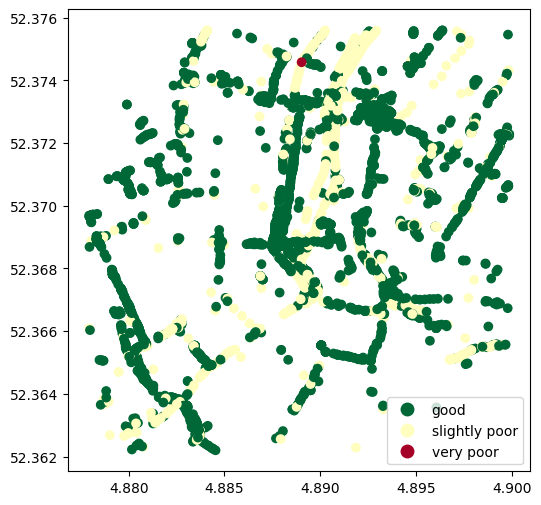

In [6]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df.quality, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
gdf.plot(column='quality', cmap='RdYlGn_r', legend=True, figsize=(10, 6))

## Utility functions

In [43]:
for file in (conf.DATA_DIR / "data").glob("*.csv"):
    columns = duckdb.sql(f"SELECT * FROM read_csv('{file}') LIMIT 0").columns
    print(f"{file.name}: {columns}")

metadata_common_attributes.csv: ['uuid', 'source', 'orig_id', 'lat', 'lon', 'datetime_local', 'year', 'month', 'day', 'hour', 'width', 'height', 'heading', 'projection_type', 'hFoV', 'vFoV', 'sequence_index', 'sequence_id', 'sequence_img_count']
simplemaps.csv: ['uuid', 'source', 'orig_id', 'city', 'city_ascii', 'city_id', 'city_lat', 'city_lon', 'country', 'iso2', 'iso3', 'admin_name', 'capital', 'population', 'continent']
segmentation.csv: ['uuid', 'source', 'orig_id', 'Bird', 'Ground-Animal', 'Curb', 'Fence', 'Guard-Rail', 'Barrier', 'Wall', 'Bike-Lane', 'Crosswalk---Plain', 'Curb-Cut', 'Parking', 'Pedestrian-Area', 'Rail-Track', 'Road', 'Service-Lane', 'Sidewalk', 'Bridge', 'Building', 'Tunnel', 'Person', 'Bicyclist', 'Motorcyclist', 'Other-Rider', 'Lane-Marking---Crosswalk', 'Lane-Marking---General', 'Mountain', 'Sand', 'Sky', 'Snow', 'Terrain', 'Vegetation', 'Water', 'Banner', 'Bench', 'Bike-Rack', 'Billboard', 'Catch-Basin', 'CCTV-Camera', 'Fire-Hydrant', 'Junction-Box', 'Mailbo

In [50]:
duckdb.sql(f"SELECT DISTINCT city FROM read_csv('{conf.DATA_DIR / "data"}/simplemaps.csv')")

┌────────────────────────────────────┐
│                city                │
│              varchar               │
├────────────────────────────────────┤
│ Costa Mesa                         │
│ Redmond                            │
│ Jakarta                            │
│ San Martin Texmelucan de Labastida │
│ Saint-Jean-de-la-Ruelle            │
│ Shelby                             │
│ Liège                              │
│ Indaial                            │
│ Kansas City                        │
│ Netanya                            │
│    ·                               │
│    ·                               │
│    ·                               │
│ Sri Jayewardenepura Kotte          │
│ Lusaka                             │
│ Accra                              │
│ Cayenne                            │
│ Al ‘Ayn                            │
│ Örnsköldsvik                       │
│ Huế                                │
│ Acapulco de Juárez                 │
│ Baltimore Highlands    

In [21]:
# Convert all csvs in data dir to parquet 
for file in (conf.DATA_DIR / "data").glob("*.csv"):
    print(file)
    duckdb.sql(f"""
        COPY '{file}'
        TO '{file.with_suffix(".parquet")}' 
        (FORMAT 'parquet', COMPRESSION 'zstd')
    """)


/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/metadata_common_attributes.csv
/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/simplemaps.csv
/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/segmentation.csv
/home/peter/urban-m4/streetscapes/local/streetscapes-data/data/contextual.csv


In [14]:
csv_size = sum(file.stat().st_size for file in (conf.DATA_DIR / "data").glob("*.csv") if file.is_file())
parquet_size = sum(file.stat().st_size for file in (conf.DATA_DIR / "data").glob("*.parquet") if file.is_file())

def human_readable(size):
    """Format byte size in human readable format"""
    order_of_magnitude = size.bit_length() // 10  # Dividing by 10 for base-1024 magnitude
    match order_of_magnitude:
        case 3:
            return f"{size / 1024**3:.2f} GB"
        case 2:
            return f"{size / 1024**2:.2f} MB"
        case 1:
            return f"{size / 1024:.2f} KB"
        case _:
            return f"{size} bytes"

print(f"{human_readable(csv_size)=}, {human_readable(parquet_size)=}")


human_readable(csv_size)='8.81 GB', human_readable(parquet_size)='3.29 GB'


For some usecases it might be more convenient to combine several (if not all) columns in a single table. If we use JOIN like above on the full table, we quickly run into memory issues. This is because `duckdb.sql(...)` creates an in-memory database to load the data and keep track of intermediate results. Alternatively, duckdb can create a persistent database on disk using `duckdb.connect('database_filename')`. Here, we combine all csvs into a single parquet file. 

In [ ]:
with duckdb.connect("duck.db", config={'threads': 1}) as con:
    # First we need to copy the content of each csv file into the database
    con.sql(f"CREATE TABLE contextual AS SELECT * FROM '{conf.DATA_DIR}/data/contextual.parquet'")
    con.sql(f"CREATE TABLE simplemaps AS SELECT * FROM '{conf.DATA_DIR}/data/simplemaps.parquet'")
    con.sql(f"CREATE TABLE metadata AS SELECT * FROM '{conf.DATA_DIR}/data/metadata_common_attributes.parquet'")
    con.sql(f"CREATE TABLE segmentation AS SELECT * FROM '{conf.DATA_DIR}/data/segmentation.parquet'")

    # Now we can perform the joins. We will do it step by step to keep checks on the memory needed to perform each join.
    con.sql("CREATE TABLE step1 AS SELECT * FROM contextual JOIN metadata USING (UUID, source, orig_id)")
    con.sql("CREATE TABLE step2 AS SELECT * FROM step1 JOIN simplemaps USING (UUID, source, orig_id)")
    con.sql("CREATE TABLE step3 AS SELECT * FROM step2 JOIN segmentation USING (UUID, source, orig_id)")

    # Finally, we can export the joined table to a new parquet file
    con.sql(f"COPY step3 TO '{conf.DATA_DIR}/data/combined.parquet' (FORMAT 'parquet', COMPRESSION 'zstd')")

# Remove the database from our filesystem
os.remove("duck.db")

# Show the combined file size:
combined_size = (conf.DATA_DIR / "data" / "combined.parquet").stat().st_size
print(f"{human_readable(combined_size)=}")

In [5]:
# Let's inspect the new file to see if the join has worked
duckdb.sql(f"SELECT * FROM '{conf.DATA_DIR}/data/combined.parquet'")

┌──────────────────────────────────────┬───────────┬──────────────────┬─────────┬────────────────────┬─────────────┬─────────────────┬───────────────┬────────────┬────────────────┬─────────┬─────────────────────┬─────────────────────┬─────────────────────────┬───────┬───────┬───────┬───────┬────────┬────────┬────────────────────┬─────────────────┬────────────────────┬────────────────────┬────────────────┬────────────────────────┬────────────────────┬───────────────┬───────────────┬────────────┬──────────┬───────────┬────────────────┬─────────┬─────────┬────────────────────────┬─────────┬────────────┬───────────────┬────────┬───────────────┬─────────┬──────────┬────────────┬──────────┬──────────┬───────────┬───────────────────┬──────────┬─────────┬─────────────────┬────────────┬───────────┬──────────────┬──────────┬──────────┬───────────┬────────┬─────────┬───────────┬──────────────┬─────────────┬──────────────────────────┬────────────────────────┬──────────┬────────┬───────────┬───────